# Demystifying Gaussian Process Regression

Let's generate some fake, one dimensional data, which we'll fit with various techniques.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

ndim = 10

x = np.arange(ndim)[:, np.newaxis]
y = np.arange(ndim)[:, np.newaxis]

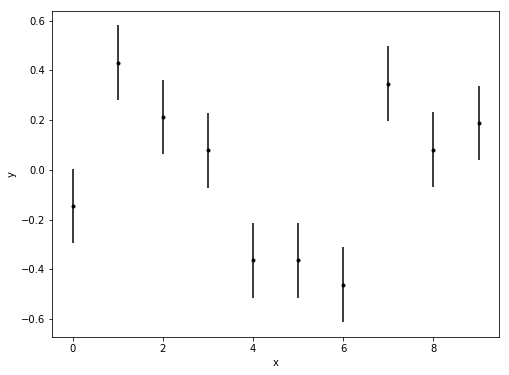

In [2]:
np.random.seed(42)
y = np.random.rand(ndim)[:, None]
y -= y.mean()
x = np.arange(len(y))[:, None]
yerr = y.std() / 2 * np.ones_like(x)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.xlabel('x')
plt.ylabel('y');

# Linear regression

Solutions to the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) estimators $\hat{\beta}$ are

$$ \hat{\beta} = ({\bf X}^\top {\bf N}^{-1} {\bf X})^{-1} {\bf X}^\top {\bf N}^{-1} y,$$

and their uncertainties are given by

$$ \mathrm{cov} = {\bf X}^\top {\bf N}^{-1} {\bf X}, $$

where ${\bf N}$ is the matrix of uncertainties on measurements $y$ (${\bf N}$ is diagonal for measurements with independent Gaussian uncertainties, in this case). 

In [3]:
# Append a column of ones next to the `x` values using `np.vander`: 
X = np.vander(x.ravel(), 2)
inv_N = np.linalg.inv(np.identity(len(x)) * yerr**2)

# Solve linear regression: 
betas = np.linalg.inv(X.T @ inv_N @ X) @ X.T @ inv_N @ y
cov = np.linalg.inv(X.T @ inv_N @ X)

# Compute best fit line: 
best_fit = X @ betas 
err = np.sqrt(np.diag(cov))

Plot the result and its uncertainty (here we're plotting just the uncertainty in the intercept and ignoring the uncertainty in the slope, for this example)

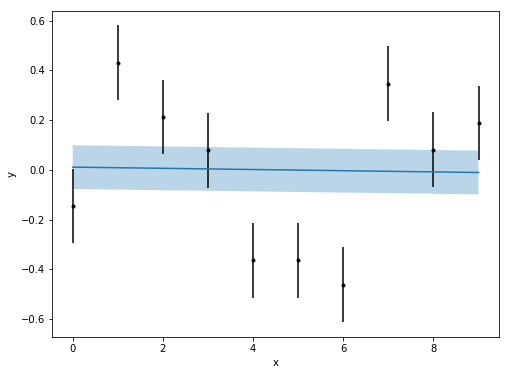

In [4]:
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.plot(x, best_fit)
plt.fill_between(x.ravel(), best_fit.ravel()-err[1], best_fit.ravel()+err[1], alpha=0.3)
plt.xlabel('x')
plt.ylabel('y');

# Gaussian process regression

From [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/), the predicted mean is going to be (Equation 2.25) 

$$ \mu = {\bf k_*}^\top ({\bf K} + \sigma_n {\bf I})^{-1} {\bf y},  $$

and the covariance is going to be (Equation 2.26)

$$ \mathrm{cov} = k({\bf x_*}, {\bf x_*})- {\bf k_*}^\top ({\bf K }+ \sigma_n {\bf I})^{-1} {\bf k_*}, $$ 

and therefore the error on the predictions will be

$$ \mathrm{err} = \mathrm{diag}\left( \sqrt{\mathrm{cov}} \right).$$

Define a "squared exponential" (Gaussian) kernel function

$$ K({\bf x_1}, {\bf x_2}) = \sigma^2 \exp\left(-\frac{(x_1 - x_2)^2)}{2 \ell^2}\right)   $$

In [5]:
def square_distance(x1, x2): 
    """
    Compute the squared distance between two vectors `x1` and `x2` 
    
    Note that (x1 - x2)^2 = x1^2 + x2^2 - 2 * x1 * x2, so we can use the short syntax below
    to avoid loops: 
    
    For reference, see: 
    https://medium.com/dataholiks-distillery/l2-distance-matrix-vectorization-trick-26aa3247ac6c
    """
    return np.sum(x1**2, axis=1)[:, np.newaxis] + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)

def sq_exp_kernel(x1, x2, sigma=1, ell=1): 
    """
    Gaussian Kernel function
    """
    sqdist = square_distance(x1, x2)

    return sigma**2 * np.exp(-0.5 * sqdist / ell**2)

def gaussian_process_regression(x, y, yerr, xtest, kernel): 
    """
    Gaussian process regression for column vectors `x` and `y` with 
    uncertainties `yerr`; predict values at `xtest` using `kernel`
    """
    K = kernel(x, x) + np.identity(len(x)) * yerr**2
    k_s = kernel(x, xtest)
    k_ss = kernel(xtest, xtest)
    inv_K = np.linalg.inv(K)
    # The `@` operator in python 3 is the matrix multiplication operator
    mu = k_s.T @ inv_K @ y
    cov = k_ss - k_s.T @ inv_K @ k_s
    return mu, cov

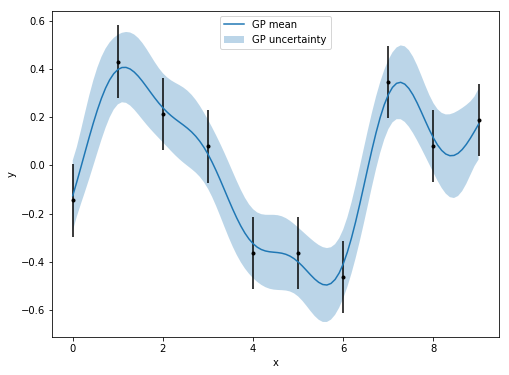

In [6]:
N = 100
xtest = np.linspace(x.min(), x.max(), N)[:, np.newaxis]

mu, cov = gaussian_process_regression(x, y, yerr, xtest, sq_exp_kernel)

err = np.sqrt(np.diagonal(cov))

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.plot(xtest.ravel(), mu.ravel(), label='GP mean')
plt.fill_between(xtest.ravel(), mu.ravel()-err, mu.ravel()+err, alpha=0.3, label='GP uncertainty')
plt.legend(loc='upper center')
plt.xlabel('x')
plt.ylabel('y');

### Square-Exponential (Gaussian) Kernel

which allows you to vary the $\ell$ hyperparameter and see the results: 

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [14]:
def gp_interact(ell):
    def sq_exp_kernel_interactive(x1, x2, sigma=1, ell=ell): 
        """
        Interactive Gaussian Kernel function
        """
        sqdist = square_distance(x1, x2)

        return sigma**2 * np.exp(-0.5 * sqdist / ell**2)
    
    mu, cov = gaussian_process_regression(x, y, yerr, xtest, sq_exp_kernel_interactive)
    err = np.sqrt(np.diag(cov))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].errorbar(x, y, yerr, fmt='.', color='k')
    ax[0].plot(xtest.ravel(), mu.ravel(), label='GP Mean')
    ax[0].fill_between(xtest.ravel(),  mu.ravel()-err, mu.ravel()+err, alpha=0.2, label='GP Uncertainty')
    ax[0].set(xlabel='$x$', ylabel='$y$', title='GP Regression')
    ax[0].legend(loc='upper center')
    
    ax[1].set(xlabel='$x_1$', ylabel='$x_2$', title='Covariance matrix')
    ax[1].imshow(sq_exp_kernel_interactive(x, x))
    
    plt.show()

print('Vary the hyperparameter "ell", which defines the autocorrelation timescale:')
interactive_plot = interactive(gp_interact, ell=(1, 10, 1))
output = interactive_plot.children[-1]
interactive_plot

Vary the hyperparameter "ell", which defines the autocorrelation timescale:


interactive(children=(IntSlider(value=5, description='ell', max=10, min=1), Output()), _dom_classes=('widget-interact',))

### Exponential-cosine kernel 

In [18]:
def gp_interact(ell, period):
    def exp_cos(x1, x2, sigma=1, ell=ell, period=period): 
        """
        Interactive Gaussian Kernel function
        """
        sqdist = square_distance(x1, x2)

        return sigma**2 * np.exp(-0.5 * sqdist / ell**2) * np.cos(2*np.pi*np.sqrt(sqdist)/period)
    
    mu, cov = gaussian_process_regression(x, y, yerr, xtest, exp_cos)
    err = np.sqrt(np.diag(cov))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].errorbar(x, y, yerr, fmt='.', color='k')
    ax[0].plot(xtest.ravel(), mu.ravel(), label='GP Mean')
    ax[0].fill_between(xtest.ravel(),  mu.ravel()-err, mu.ravel()+err, alpha=0.2, label='GP Uncertainty')
    ax[0].set(xlabel='$x$', ylabel='$y$', title='GP Regression')
    ax[0].legend(loc='upper center')
    
    ax[1].set(xlabel='$x_1$', ylabel='$x_2$', title='Covariance matrix')
    ax[1].imshow(exp_cos(x, x))
    
    plt.show()

print('Vary the hyperparameters "ell" and "period", which define the autocorrelation timescale:')
interactive_plot = interactive(gp_interact, ell=(1, 10, 1), period=(1, 10, 1))
output = interactive_plot.children[-1]
interactive_plot

Vary the hyperparameter "ell", which defines the autocorrelation timescale:


interactive(children=(IntSlider(value=5, description='ell', max=10, min=1), IntSlider(value=5, description='period', max=10, min=1), Output()), _dom_classes=('widget-interact',))